# Building a Recommendation System 

I'm going to attempt to create a `collaborative filtering` system using `matrix factorization` to get all my embeddings straight and then I'm going to top it off with a `k-means` clustering algorithm to get my prediction to see in general how well i have done collaborative filtering .

#### problem : cold start

### What Is Collaborative Filtering ??.

*[Collaborative filtering](https://medium.com/@ashmi_banerjee/understanding-collaborative-filtering-f1f496c673fd)*: It is a technique that relies on the preferences of other users to recommend certain unused items. The basic idea is that users who had similar preferences in the past may be interested in the same item in the future.

> Example: If there are two users *A* and *B*, and if user *A* likes a certain movie and user *B* likes movies, then it is possible that user *B* likes the same movie that *A* likes.

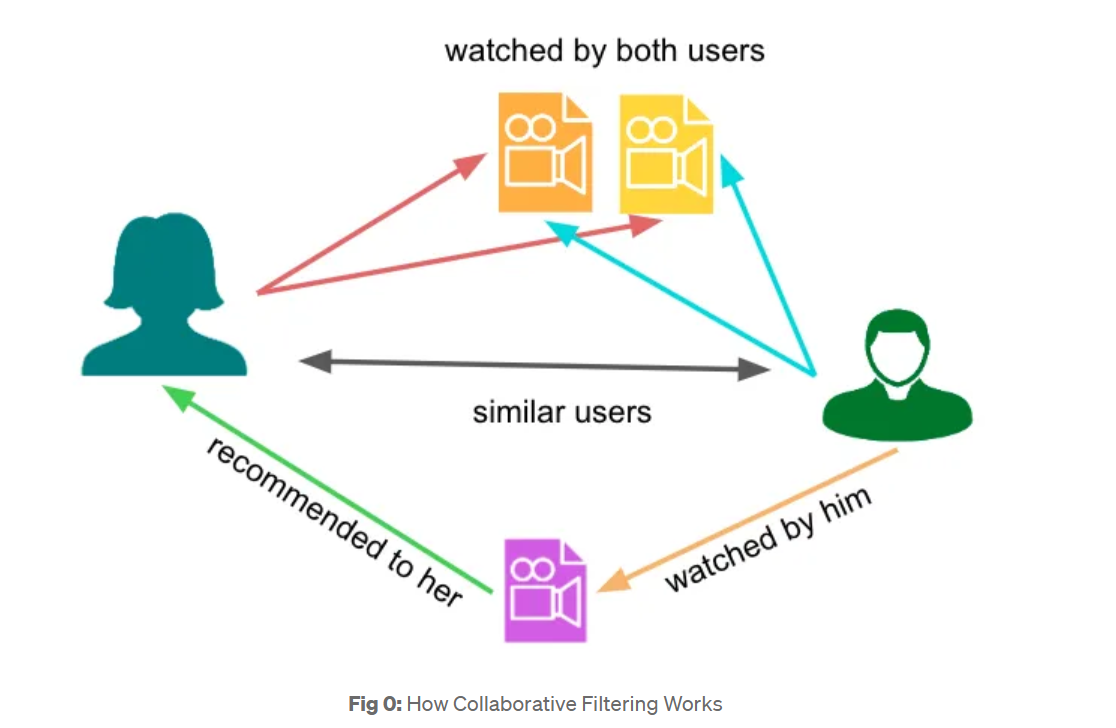

### What Is Matrix Factorization ??.

[*Matrix Factorization*](https://medium.com/@ilyurek/understanding-matrix-factorization-a-simple-guide-20e2b32989eb) is a technique widely used in recommender systems, especially in **Collaborative Filtering** applications. It relies on dividing a large matrix representing user interactions with items (such as ratings) into two smaller matrices containing reduced representations of both users and items, with the aim of discovering hidden patterns.

Explain the basic idea:
Suppose you have a matrix of users and items (such as movies or products), where each row represents a user and each column represents an item, and the cells contain interactions (such as ratings). Most of this matrix may contain missing values ​​(i.e. not all items were rated by all users).

Matrix Factorization is used to complete this matrix by dividing it into:

1. User Matrix: contains reduced representations for each user.
2. Item Matrix: contains reduced representations for each item.

These two matrices can be used to reconstruct the original matrix approximately, even for missing values.

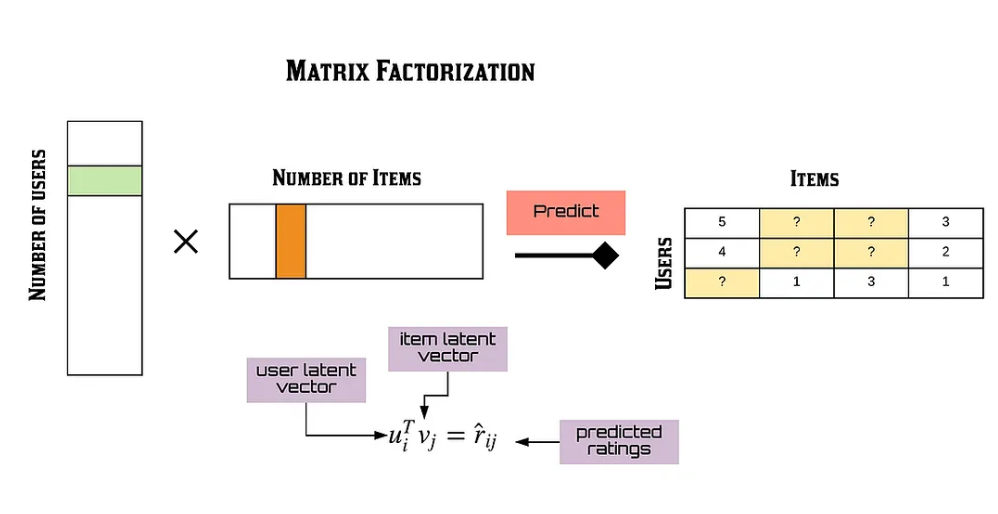

# 🗂️ Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import numpy as np


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# 📈 Download DataSet

I will use `MovieLens` dataset for my project, which is a popular dataset for movie ratings.
I will download it from the GroupLens website.

In [2]:
! curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   978k      0 --:--:-- --:--:-- --:--:--  977k


In [3]:
# extracts the contents of the ml-latest-small.zip file to a directory named data.
# This is useful when you need to access the files inside the ZIP archive.
import zipfile
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [4]:
# import the dataset
import pandas as pd
movies_df = pd.read_csv('data/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('data/ml-latest-small/ratings.csv')

# 📊 Data analysis with the MovieLens dataset.

In [5]:
print('The dimensions of movies dataframe are:', movies_df.shape,'\nThe dimensions of ratings dataframe are:', ratings_df.shape)

The dimensions of movies dataframe are: (9742, 3) 
The dimensions of ratings dataframe are: (100836, 4)


In [6]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [7]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [8]:
print(movies_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


In [9]:
print(ratings_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


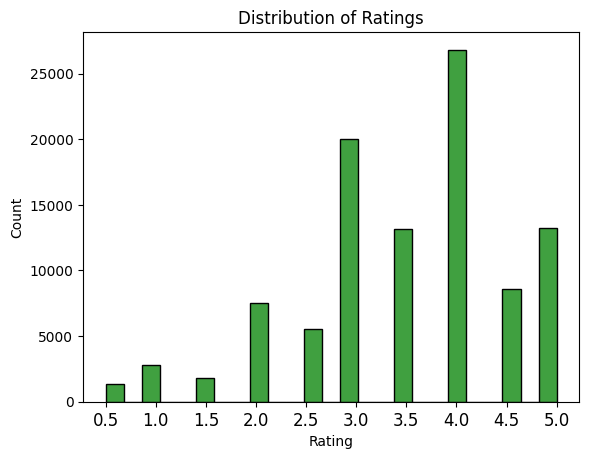

In [10]:
# Distribution of ratings
sns.histplot(ratings_df['rating'], bins=25, color='green', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

# Sort unique values
unique_ratings = np.sort(ratings_df['rating'].unique())

# Modify the label on the X axis using ordered values
plt.xticks(ticks=unique_ratings, labels=unique_ratings, fontsize=12, rotation=0)

plt.show()

In [11]:
# Calculating some important statistics
stats = {
    'Total number of ratings': len(ratings_df),
    'Average overall rating': ratings_df['rating'].mean(),
    'Standard deviation of ratings': ratings_df['rating'].std(),
    'Number of active users': len(ratings_df['userId'].unique()),
    'Average number of ratings per user': len(ratings_df) / len(ratings_df['userId'].unique())
}

for key, value in stats.items():
    print(f"{key}: {value:.2f}")

Total number of ratings: 100836.00
Average overall rating: 3.50
Standard deviation of ratings: 1.04
Number of active users: 610.00
Average number of ratings per user: 165.30


In [12]:
# Movie ID to movie name mapping
movie_names = movies_df.set_index('movieId')['title'].to_dict()

# Calculate the number of unique users and movies
n_users = len(ratings_df.userId.unique())
n_items = len(ratings_df.movieId.unique())

# Print the results
print("Number of unique users:", n_users)
print("Number of unique movies:", n_items)
print("The full rating matrix will have:", n_users * n_items, 'elements.')
print('---------------------------------------------------------------------')
print("Number of ratings:", len(ratings_df))
print("Therefore: ", len(ratings_df) / (n_users * n_items) * 100, '% of the matrix is filled.')

Number of unique users: 610
Number of unique movies: 9724
The full rating matrix will have: 5931640 elements.
---------------------------------------------------------------------
Number of ratings: 100836
Therefore:  1.6999683055613624 % of the matrix is filled.


We have an incredibly sparse matrix to work with here.
And... as the number of users and products grow, the number of elements will increase by **n*2**

You are going to need a lot of memory to work with global scale... storing a full matrix in memory would be a challenge.
One advantage here is that matrix factorization can realize the rating matrix implicitly, thus we don't need all the data.

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 📖 Matrix Factorization, Model Initialization & Training Model

In [14]:
# 1. Define Dataset
class MovieDataset(Dataset):
    def __init__(self, ratings_df, user_to_idx, movie_to_idx):
        self.users = torch.tensor([user_to_idx[user] for user in ratings_df['userId']], dtype=torch.long)
        self.movies = torch.tensor([movie_to_idx[movie] for movie in ratings_df['movieId']], dtype=torch.long)
        self.ratings = torch.tensor(ratings_df['rating'].values, dtype=torch.float)
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

In [15]:
# 2. Define Matrix Factorization model
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_movies, n_factors=50):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.movie_factors = nn.Embedding(n_movies, n_factors)
        self.user_biases = nn.Embedding(n_users, 1)
        self.movie_biases = nn.Embedding(n_movies, 1)
        
    def forward(self, user, movie):
        user_embedding = self.user_factors(user)
        movie_embedding = self.movie_factors(movie)
        user_bias = self.user_biases(user)
        movie_bias = self.movie_biases(movie)
        
        prediction = (user_embedding * movie_embedding).sum(dim=1, keepdim=True)
        prediction = prediction + user_bias + movie_bias
        return prediction.squeeze()
    
    def get_embeddings(self, user, movie):
        """Extract user and movie embeddings"""
        user_embedding = self.user_factors(user)
        movie_embedding = self.movie_factors(movie)
        return user_embedding, movie_embedding

In [16]:
# 3. Combined model with Matrix Factorization and K-means
class CombinedRecommender:
    def __init__(self, n_users, n_movies, n_factors=50, n_clusters=5):
        self.mf_model = MatrixFactorization(n_users, n_movies, n_factors)
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.n_factors = n_factors
        self.n_clusters = n_clusters
        
    def train_mf(self, train_loader, test_loader, n_epochs=10):
        """Train Matrix Factorization model"""
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.mf_model.parameters(), lr=0.01)
        
        train_losses = []
        test_losses = []
        
        for epoch in range(n_epochs):
            # Train the model
            self.mf_model.train()
            total_train_loss = 0
            for users, movies, ratings in train_loader:
                optimizer.zero_grad()
                predictions = self.mf_model(users, movies)
                loss = criterion(predictions, ratings)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
            
            # Evaluate the model
            self.mf_model.eval()
            total_test_loss = 0
            with torch.no_grad():
                for users, movies, ratings in test_loader:
                    predictions = self.mf_model(users, movies)
                    loss = criterion(predictions, ratings)
                    total_test_loss += loss.item()
            
            train_losses.append(total_train_loss / len(train_loader))
            test_losses.append(total_test_loss / len(test_loader))
            
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Training Loss: {train_losses[-1]:.4f}')
            print(f'Test Loss: {test_losses[-1]:.4f}')
        
        return train_losses, test_losses
    
    def get_combined_embeddings(self, users, movies):
        """Combine user and movie embeddings"""
        self.mf_model.eval()
        with torch.no_grad():
            user_emb, movie_emb = self.mf_model.get_embeddings(users, movies)
            combined_emb = torch.cat([user_emb, movie_emb], dim=1)
            return combined_emb.numpy()
    
    def train_kmeans(self, train_loader):
        """Train K-means on combined embeddings"""
        all_embeddings = []
        all_ratings = []
        
        self.mf_model.eval()
        with torch.no_grad():
            for users, movies, ratings in train_loader:
                combined_emb = self.get_combined_embeddings(users, movies)
                all_embeddings.append(combined_emb)
                all_ratings.extend(ratings.numpy())
        
        all_embeddings = np.vstack(all_embeddings)
        all_ratings = np.array(all_ratings)
        
        # Train K-means
        self.kmeans.fit(all_embeddings)
        self.cluster_ratings = {}
        
        # Calculate the average rating per cluster
        clusters = self.kmeans.predict(all_embeddings)
        for i in range(self.n_clusters):
            self.cluster_ratings[i] = np.mean(all_ratings[clusters == i])
    
    def predict(self, users, movies):
        """Predict using the combined model"""
        combined_emb = self.get_combined_embeddings(users, movies)
        clusters = self.kmeans.predict(combined_emb)
        
        # Get predictions from Matrix Factorization
        mf_predictions = self.mf_model(users, movies).numpy()
        
        # Adjust predictions using cluster information
        cluster_predictions = np.array([self.cluster_ratings[c] for c in clusters])
        
        # Combine predictions (weights can be adjusted)
        final_predictions = 0.7 * mf_predictions + 0.3 * cluster_predictions
        return final_predictions

In [17]:
# 4. Training and evaluation
def train_and_evaluate(ratings_df, n_factors=50, n_clusters=5):
    # Prepare data
    user_ids = ratings_df['userId'].unique()
    movie_ids = ratings_df['movieId'].unique()
    
    user_to_idx = {user: idx for idx, user in enumerate(user_ids)}
    movie_to_idx = {movie: idx for idx, movie in enumerate(movie_ids)}
    
    # Split data
    train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)
    
    # Create DataLoaders
    train_dataset = MovieDataset(train_df, user_to_idx, movie_to_idx)
    test_dataset = MovieDataset(test_df, user_to_idx, movie_to_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
    
    # Create and train the combined model
    model = CombinedRecommender(len(user_ids), len(movie_ids), n_factors, n_clusters)
    
    # 1. Train Matrix Factorization
    print("Training Matrix Factorization...")
    train_losses, test_losses = model.train_mf(train_loader, test_loader)
    
    # 2. Train K-means
    print("\nTraining K-means...")
    model.train_kmeans(train_loader)
    
    # Evaluate the model
    print("\nEvaluating model...")
    model.mf_model.eval()
    all_predictions = []
    all_actuals = []
    
    with torch.no_grad():
        for users, movies, ratings in test_loader:
            predictions = model.predict(users, movies)
            all_predictions.extend(predictions)
            all_actuals.extend(ratings.numpy())
    
    # Compute and display performance metrics
    mse = mean_squared_error(all_actuals, all_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_actuals, all_predictions)
    
    print(f"\nFinal Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    # Visualize the results
    plt.figure(figsize=(15, 5))
    
    # Plot learning curve
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Predictions vs Actuals
    plt.subplot(1, 3, 2)
    plt.scatter(all_actuals, all_predictions, alpha=0.1)
    plt.plot([1, 5], [1, 5], 'r--')
    plt.title('Predictions vs Actuals')
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    
    # Plot cluster distribution
    plt.subplot(1, 3, 3)
    combined_emb = model.get_combined_embeddings(
        train_dataset.users[:1000], 
        train_dataset.movies[:1000]
    )
    clusters = model.kmeans.predict(combined_emb)
    
    # Use t-SNE for dimensionality reduction
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_emb = tsne.fit_transform(combined_emb)
    
    plt.scatter(reduced_emb[:, 0], reduced_emb[:, 1], c=clusters, cmap='viridis')
    plt.title('Cluster Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return model

# 🔁 Train The Model

Training Matrix Factorization...
Epoch 1/10
Training Loss: 53.2117
Test Loss: 42.2050
Epoch 2/10
Training Loss: 26.2496
Test Loss: 30.5702
Epoch 3/10
Training Loss: 14.6853
Test Loss: 23.7261
Epoch 4/10
Training Loss: 8.8142
Test Loss: 19.4090
Epoch 5/10
Training Loss: 5.6285
Test Loss: 16.5552
Epoch 6/10
Training Loss: 3.8161
Test Loss: 14.5866
Epoch 7/10
Training Loss: 2.7235
Test Loss: 13.1770
Epoch 8/10
Training Loss: 2.0402
Test Loss: 12.1250
Epoch 9/10
Training Loss: 1.5910
Test Loss: 11.3256
Epoch 10/10
Training Loss: 1.2815
Test Loss: 10.6943

Training K-means...

Evaluating model...

Final Results:
RMSE: 2.3866
MAE: 1.7361


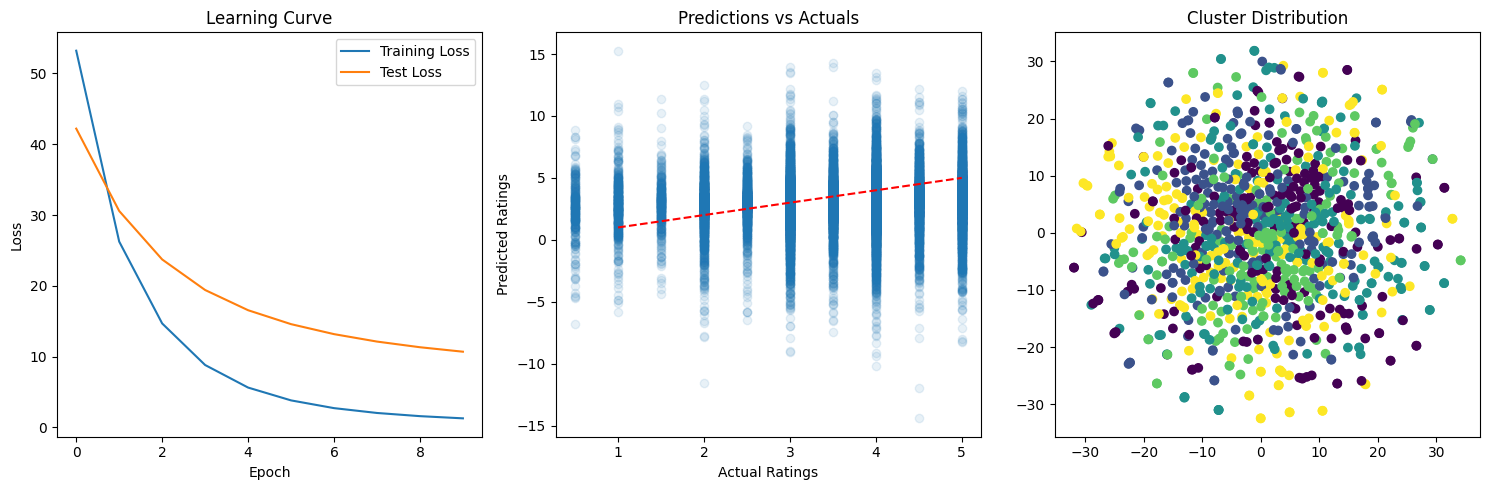

In [18]:
model = train_and_evaluate(ratings_df)

# 💿 Save The Model

In [19]:
torch.save({
    'mf_model_state_dict': model.mf_model.state_dict(),
    'kmeans_model': model.kmeans,
    'cluster_ratings': model.cluster_ratings
}, 'combined_recommender_model.pth')

#### Let's also add a comprehensive evaluation that includes `confusion matrix` and additional analysis:

# 🚀 comprehensive evaluation

In [20]:
class AdvancedModelEvaluation:
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.evaluate()
    
    def evaluate(self):
        """Comprehensive model evaluation"""
        self.model.mf_model.eval()
        self.predictions = []
        self.actuals = []
        self.embeddings = []
        self.clusters = []
        
        with torch.no_grad():
            for users, movies, ratings in self.test_loader:
                # Get predictions and embeddings
                preds = self.model.predict(users, movies)
                emb = self.model.get_combined_embeddings(users, movies)
                clusters = self.model.kmeans.predict(emb)
                
                self.predictions.extend(preds)
                self.actuals.extend(ratings.numpy())
                self.embeddings.append(emb)
                self.clusters.extend(clusters)
        
        self.predictions = np.array(self.predictions)
        self.actuals = np.array(self.actuals)
        self.embeddings = np.vstack(self.embeddings)
        self.clusters = np.array(self.clusters)
    
    def create_confusion_matrix(self, threshold=3.5):
        """Create a confusion matrix using a specified threshold"""
        pred_classes = (self.predictions >= threshold).astype(int)
        actual_classes = (self.actuals >= threshold).astype(int)
        
        conf_matrix = confusion_matrix(actual_classes, pred_classes)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(actual_classes, pred_classes))
    
    def analyze_clusters(self):
        """Analyze clusters and their impact on performance"""
        cluster_metrics = {}
        
        for cluster in range(self.model.n_clusters):
            # Get the indices of the data points in the current cluster
            cluster_indices = np.where(self.clusters == cluster)[0]
            cluster_predictions = self.predictions[cluster_indices]
            cluster_actuals = self.actuals[cluster_indices]
            
            # Calculate metrics for the current cluster
            mse = mean_squared_error(cluster_actuals, cluster_predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(cluster_actuals, cluster_predictions)
            
            # Store metrics in the cluster_metrics dictionary
            cluster_metrics[cluster] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'Num Samples': len(cluster_indices)
            }
        
        # Print out cluster metrics
        for cluster, metrics in cluster_metrics.items():
            print(f"\nCluster {cluster} Metrics:")
            print(f"Number of Samples: {metrics['Num Samples']}")
            print(f"MSE: {metrics['MSE']:.4f}")
            print(f"RMSE: {metrics['RMSE']:.4f}")
            print(f"MAE: {metrics['MAE']:.4f}")

    def visualize_embeddings(self):
        """Visualize the embeddings of the users and movies using PCA"""
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(self.embeddings)

        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=self.clusters, cmap='viridis', alpha=0.6)
        plt.title('PCA of User and Movie Embeddings')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.colorbar(scatter, label='Cluster')
        plt.show()

In [21]:
# Split the data into training and test set
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Define user_to_idx and movie_to_idx based on the full dataset
user_ids = ratings_df['userId'].unique()
movie_ids = ratings_df['movieId'].unique()
user_to_idx = {user: idx for idx, user in enumerate(user_ids)}
movie_to_idx = {movie: idx for idx, movie in enumerate(movie_ids)}

# Create a Dataset for the test set
test_dataset = MovieDataset(test_df, user_to_idx, movie_to_idx)

# Create a DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [22]:
evaluation = AdvancedModelEvaluation(model, test_loader)

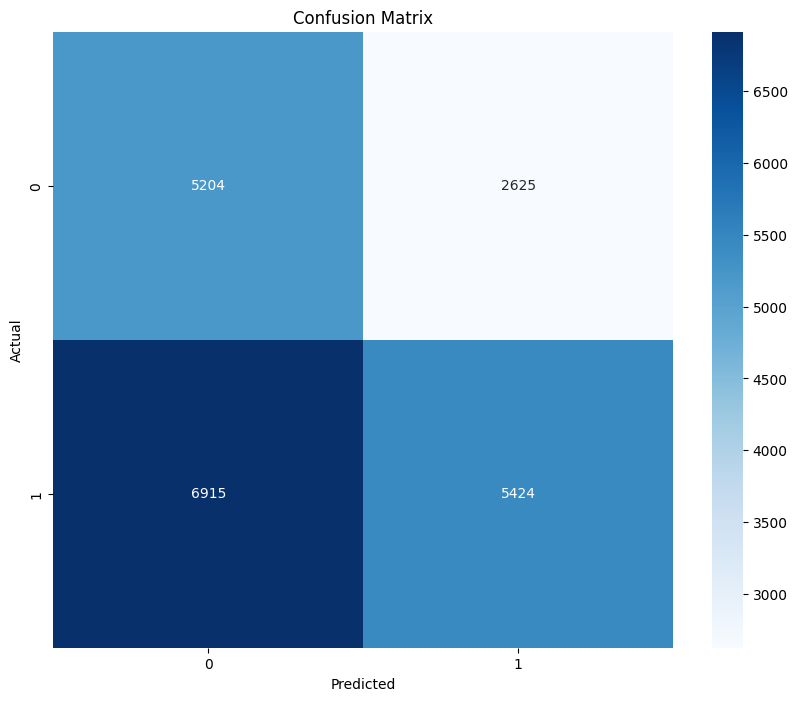


Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.66      0.52      7829
           1       0.67      0.44      0.53     12339

    accuracy                           0.53     20168
   macro avg       0.55      0.55      0.53     20168
weighted avg       0.58      0.53      0.53     20168



In [23]:
evaluation.create_confusion_matrix(threshold=3.5)

In [24]:
evaluation.analyze_clusters()


Cluster 0 Metrics:
Number of Samples: 4018
MSE: 5.7193
RMSE: 2.3915
MAE: 1.7494

Cluster 1 Metrics:
Number of Samples: 4278
MSE: 5.3124
RMSE: 2.3049
MAE: 1.6751

Cluster 2 Metrics:
Number of Samples: 4353
MSE: 5.5545
RMSE: 2.3568
MAE: 1.7262

Cluster 3 Metrics:
Number of Samples: 3831
MSE: 5.8540
RMSE: 2.4195
MAE: 1.7555

Cluster 4 Metrics:
Number of Samples: 3688
MSE: 6.1185
RMSE: 2.4736
MAE: 1.7838


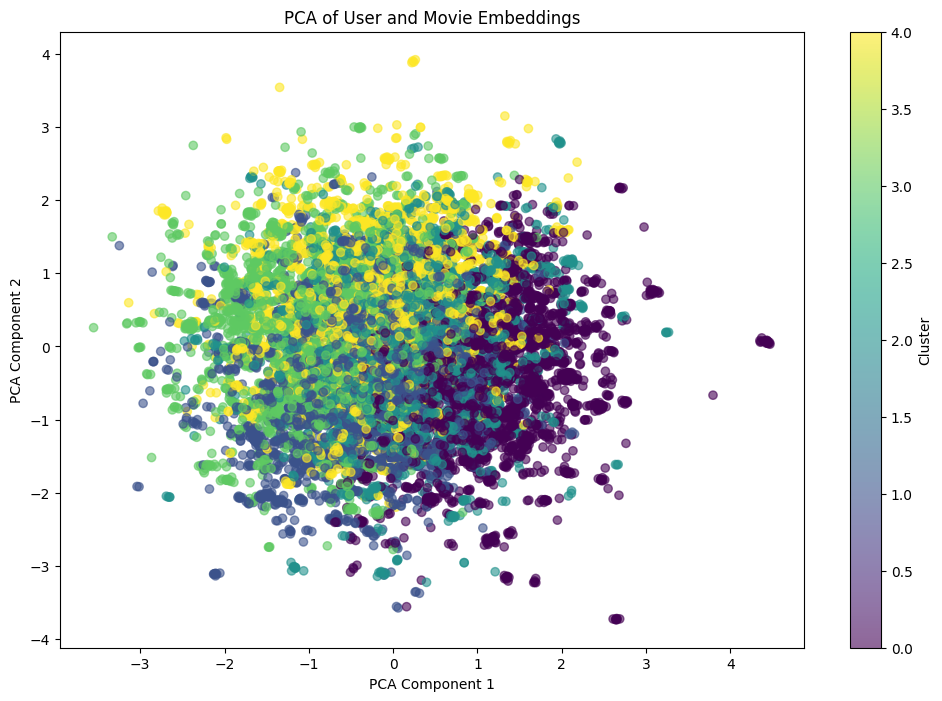

In [25]:
evaluation.visualize_embeddings()

# 🤗 Thank You 

________